# Introduction to kikuchipy

## IUMAS in Banff, Canada June 12, 2023

In this tutorial we will characterize a small (100 MB) electron backscatter diffraction (EBSD) dataset of polycrystalline recrystallized nickel by Hough indexing and pattern matching.
The results will be evaluated by using geometrical EBSD simulations and comparing indexing results to pre-indexing maps.

Steps:

1. Load and inspect data
2. Specify candidate phases
3. Calibrate detector-sample geometry (projection/pattern center)
4. Hough indexing
5. Dictionary indexing
6. Orientation refinement

Documentation of tools we use:

* kikuchipy: https://kikuchipy.org
* HyperSpy: https://hyperspy.org
* PyEBSDIndex: https://pyebsdindex.readthedocs.io
* orix: https://orix.readthedocs.io
* diffsims: https://diffsims.readthedocs.io
* EMsoft (indirectly): https://github.com/EMsoft-org/EMsoft

Import all necessary functionality

In [1]:
# Replace 'inline' for 'qt5' (from PyQt5 package) for interactive plotting
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
from orix.crystal_map import Phase, PhaseList
from orix.quaternion import Orientation
from orix import io, plot, sampling


plt.rcParams.update(
    {"figure.facecolor": "w", "font.size": 15, "figure.dpi": 75}
)

## 1. Load and inspect data

Load data (or download to cache for the first time; subsequent calls will fetch the cached data)

In [2]:
s = kp.data.ni_gain(1, allow_download=True)  # External download

100%|██████████████████████████████████████| 98.0M/98.0M [00:00<00:00, 183GB/s]
Unzipping contents of '/home/hakon/.cache/kikuchipy/0.8.6/data/scan1_gain0db.zip' to '/home/hakon/.cache/kikuchipy/0.8.6/data/ni_gain/1'


In [3]:
s

<EBSD, title: Pattern, dimensions: (200, 149|60, 60)>

For the purposes of the static display of this notebook online, we set the current navigation index to a nice pattern from a large grain

In [4]:
s.axes_manager.indices = (156, 80)

### Some pre-indexing maps

Before indexing, it is important to:
* Evaluate the pattern quality
* Get an impression of what to expect from the indexing results

To that end, we inspect three different pre-indexing maps:
* Mean pattern intensity map
* Virtual backscatter electron (VBSE) imaging RGB map
* Image quality map

Get the mean pattern intensity map

In [5]:
s_mean = s.mean(axis=(2, 3))
s_mean

<BaseSignal, title: Pattern, dimensions: (200, 149|)>

Inspect patterns in this map

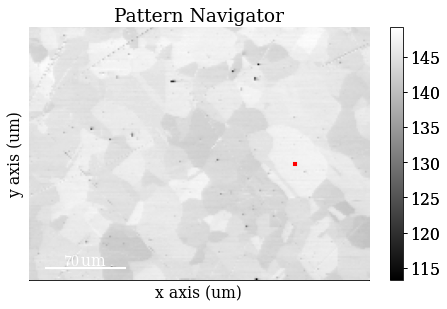

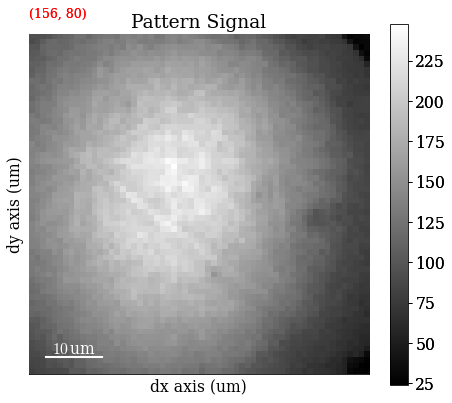

In [6]:
s.plot(s_mean)

Save mean pattern intensity map

In [7]:
plt.imsave("maps_mean.png", s_mean.data, cmap="gray")

Set up VBSE image generator

In [8]:
vbse_imager = kp.imaging.VirtualBSEImager(s)
vbse_imager

VirtualBSEImager for <EBSD, title: Pattern, dimensions: (200, 149|60, 60)>

Plot VBSE grid

<EBSD, title: Pattern, dimensions: (|60, 60)>

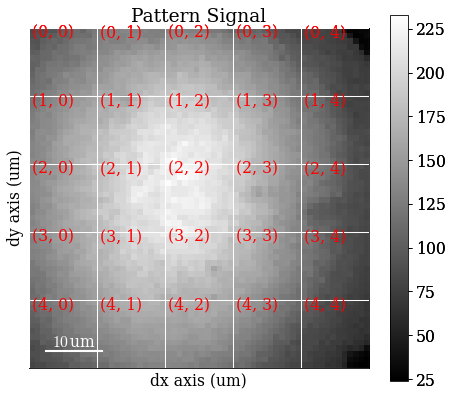

In [9]:
vbse_imager.plot_grid()

Specify RGB colour channels

In [10]:
r = (2, 1)
b = (2, 2)
g = (2, 3)

Plot coloured grid tiles

<EBSD, title: Pattern, dimensions: (|60, 60)>

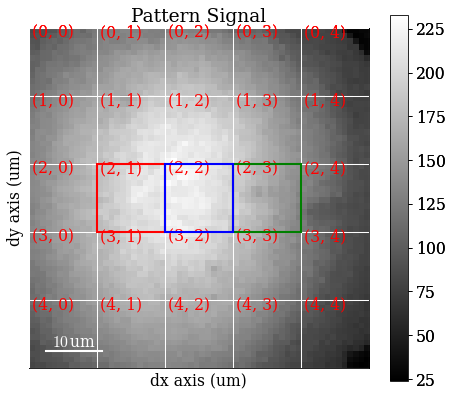

In [11]:
vbse_imager.plot_grid(rgb_channels=[r, g, b])

Get VBSE RGB image

In [12]:
vbse_rgb = vbse_imager.get_rgb_image(r, g, b)

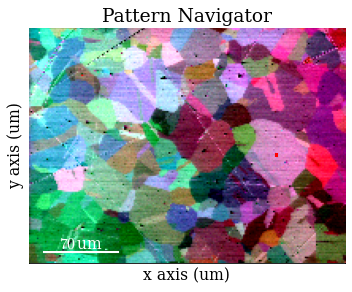

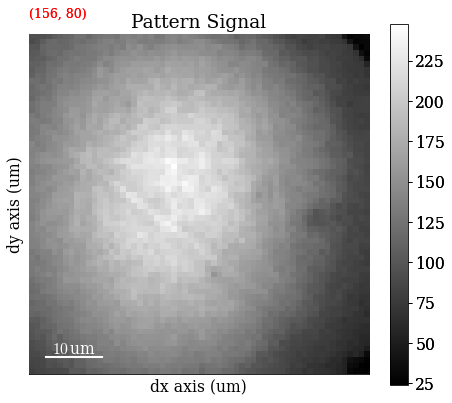

In [13]:
s.plot(vbse_rgb)

Save RGB image

In [14]:
vbse_rgb.save("maps_vbse_rgb.png", overwrite=True)

### Enhancement of Kikuchi pattern

Remove static (constant) background

In [15]:
s.remove_static_background()

[########################################] | 100% Completed | 811.60 ms


Inspect statically corrected patterns

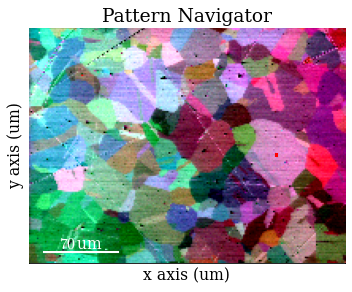

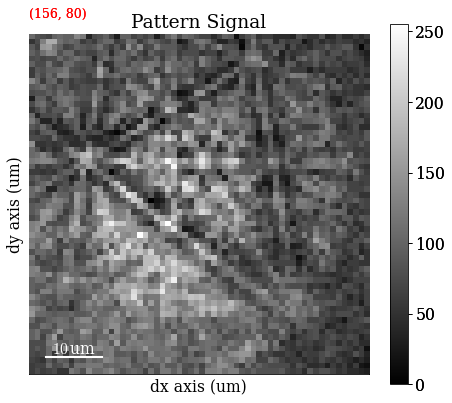

In [16]:
s.plot(vbse_rgb)

Remove dynamic (per pattern) background

In [17]:
s.remove_dynamic_background()

[########################################] | 100% Completed | 3.23 ss


Inspect dynamically corrected patterns

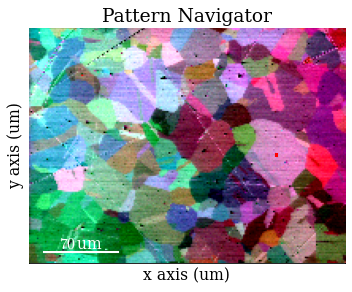

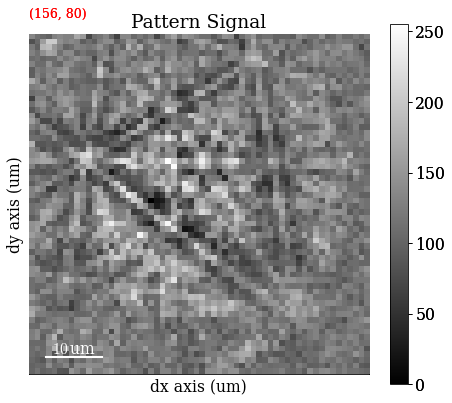

In [18]:
s.plot(vbse_rgb)

Increase the signal-to-noise (S/N) ratio by averaging each pattern with the four nearest neighbours (or any other averaging kernel you like)

In [19]:
#s.average_neighbour_patterns()

Inspect averaged patterns

In [20]:
#s.plot(vbse_rgb)

Save corrected patterns

In [21]:
#s.save("patterns.h5")

### More pre-indexing maps

Get image quality $Q$ map (not image quality IQ from Hough indexing!)

In [22]:
iq = s.get_image_quality()

[########################################] | 100% Completed | 1.72 ss


Navigate patterns in $Q$ map

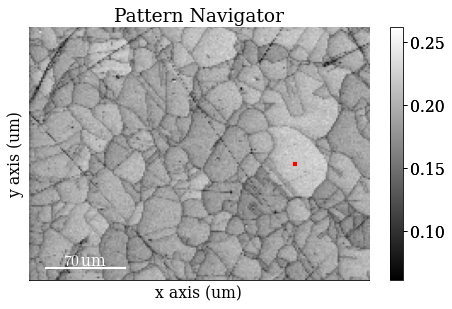

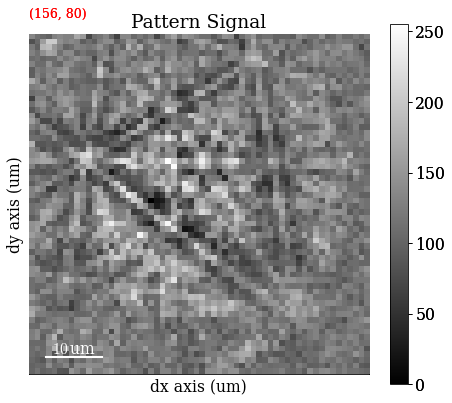

In [23]:
s.plot(hs.signals.Signal2D(iq))

Save $Q$ map

In [24]:
plt.imsave("maps_iq.png", iq, cmap="gray")

## 2. Specify candidate phases

We do not expect other phases than Ni.
We will load the master pattern of Ni (packaged with kikuchipy) created with EMsoft

In [25]:
mp = kp.data.nickel_ebsd_master_pattern_small(energy=20, projection="lambert")

Create a phase list for use in Hough indexing, and set the lattice parameters to Ångström

In [26]:
pl = PhaseList(mp.phase)
lat = pl["ni"].structure.lattice
lat.setLatPar(lat.a * 10, lat.b * 10, lat.c * 10)
pl

Id  Name  Space group  Point group  Proper point group     Color
 0    ni        Fm-3m         m-3m                 432  tab:blue

Also, load the stereographic projection which we will plot later to understand a bit more about simulations

In [27]:
mp_sp = kp.data.nickel_ebsd_master_pattern_small(energy=20, projection="stereographic")

## 3. Calibrate detector-sample geometry

Orientation of detector with respect to the sample:
* Known:
    * Sample tilt (about microscope X) = 70 degrees
    * No camera tilt (screen vertical)
* Unknown:
    * Projection/pattern center (PCx, PCy, PCz): Shortest distance from source point to detector

Load calibration patterns to get a mean PC for the data

In [28]:
s_cal = kp.data.ni_gain_calibration(1)

In [29]:
s_cal

<EBSD, title: Calibration patterns, dimensions: (9|480, 480)>

Plot pattern positions in an overview image (specific to NORDIF acquisition software)

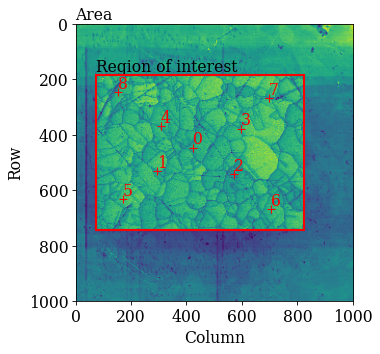

In [30]:
omd = s_cal.original_metadata

kp.draw.plot_pattern_positions_in_map(
    rc=omd.calibration_patterns.indices,
    roi_shape=omd.roi.shape,
    roi_origin=omd.roi.origin,
    roi_image=iq,
    area_shape=omd.area.shape,
    area_image=omd.area_image,
    color="r",
)

Enhance Kikuchi patterns in calibration patterns

In [31]:
s_cal.remove_static_background()
s_cal.remove_dynamic_background()

[########################################] | 100% Completed | 111.80 ms
[########################################] | 100% Completed | 101.96 ms


Inspect calibration patterns

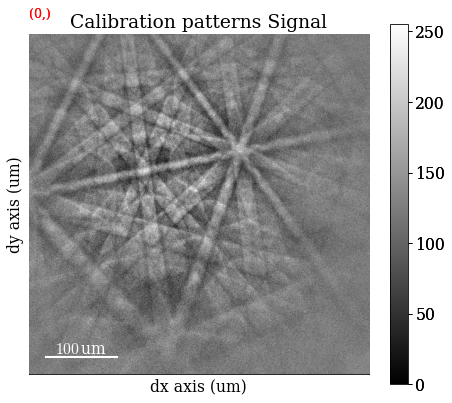

In [32]:
s_cal.plot(navigator="none")

Generate an indexer instance used to optimize the PC and to perform Hough indexing

In [33]:
indexer_cal = s_cal.detector.get_indexer(pl)

In [34]:
rlv = ReciprocalLatticeVector(pl["ni"], hkl=[[1, 1, 1], [2, 0, 0], [2, 2, 0], [3, 1, 1]])
rlv = rlv.symmetrise()
rlv.sanitise_phase()  # Complete unit cell
rlv.calculate_structure_factor()
rlv.calculate_theta(20e3)
rlv.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    2.034    11.8     140.0     100.0      8   
 2 0 0    1.762    10.4     108.2      77.3      6   
 2 2 0    1.246     7.4     55.0       39.3      12  
 3 1 1    1.062     6.2     38.6       27.6      24  


Create simulator

In [35]:
simulator = kp.simulations.KikuchiPatternSimulator(rlv)

Plot simulator

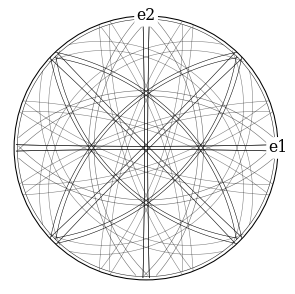

In [36]:
simulator.plot(mode="bands", axes_labels=["e1", "e2"])

Inspect default PC with gnomonic circles with 10$^{\circ}$ spacing

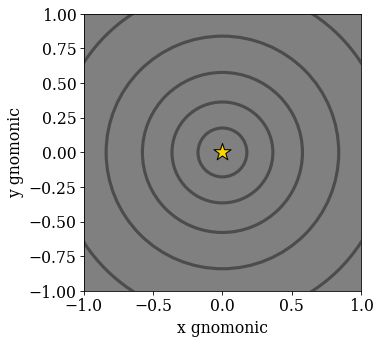

In [37]:
s_cal.detector.plot("gnomonic", draw_gnomonic_circles=True)

Optimize PC by trial and error (the initial guess is based on previous experiments on the same microscope).

NB! Running this cell the first time after installing PyEBSDIndex might cause a kernel crash...
If that happens, you have to re-run the notebook.
It should not happen again.
This is an issue we're working to solve.

All PCs:
 [[0.42121438 0.22809473 0.50094051]
 [0.42790341 0.21319761 0.50573007]
 [0.42171426 0.21138869 0.4877976 ]
 [0.41641375 0.22353226 0.5041024 ]
 [0.42045715 0.20985189 0.49608039]
 [0.4288397  0.22728138 0.50767212]
 [0.408113   0.22684657 0.50866931]
 [0.41188939 0.21814051 0.50252101]
 [0.43044458 0.20579483 0.48590131]]
Mean PC:
 [0.42077662 0.2182365  0.49993497]
Std:
 [0.0072175  0.00801777 0.00784516] 

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.4208, 0.2182, 0.4999)
  Indexing 9 pattern(s) in 1 chunk(s)
  Indexing speed: 89.44795 patterns/s

 Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0    9 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm, pq, nmatch
Scan unit: um 

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.14 ms
Finding zone axes that are in some pattern:
[#######

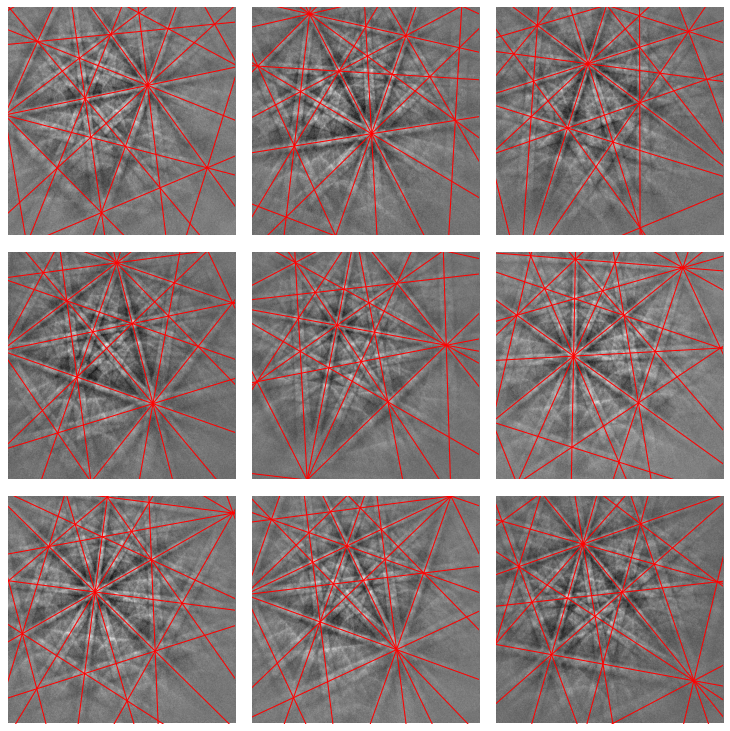

In [38]:
det_cal = s_cal.hough_indexing_optimize_pc([0.4, 0.2, 0.5], indexer_cal, batch=True)

# Print PCs and standard deviations
print("All PCs:\n", det_cal.pc)
print("Mean PC:\n", det_cal.pc_average)
print("Std:\n", det_cal.pc.std(axis=0), "\n")

# Get new indexer from detector, using the average PC
indexer_cal2 = det_cal.get_indexer(pl)

# Index calibration patterns using found PCs
xmap_cal = s_cal.hough_indexing(pl, indexer_cal2, verbose=0)
print("\n", xmap_cal, "\n")

# Create geometrical simulations for each pattern
sim_cal = simulator.on_detector(det_cal, xmap_cal.rotations)

# Plot
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10), layout="tight")
for i, ax in enumerate(axes.ravel()):
    ax.imshow(s_cal.data[i], cmap="gray")
    ax.axis("off")
    lines = sim_cal.as_collections(i)[0]
    ax.add_collection(lines)

Plot pair of PC coordinates and compare to the map of PC positions from above

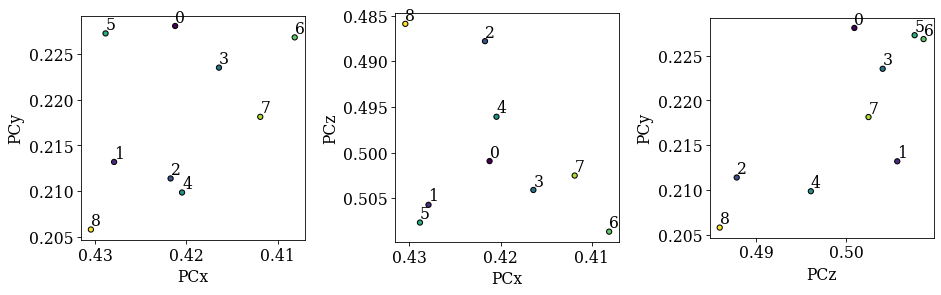

In [39]:
det_cal.plot_pc("scatter", annotate=True)

Refine PCs using pattern matching

In [40]:
xmap_cal2, det_cal2 = s_cal.refine_orientation_projection_center(
    xmap_cal,
    det_cal,
    mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[2, 2, 2, 0.02, 0.02, 0.02],
    chunk_kwargs=dict(chunk_shape=1),  # Spread across all CPUs
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [2.   2.   2.   0.02 0.02 0.02]
  Relative tolerance: 0.0001
Refining 9 orientation(s) and projection center(s):
[########################################] | 100% Completed | 28.52 ss
Refinement speed: 0.31549 patterns/s


Extrapolate from the mean of all nine PCs to the full map shape to get one PC per point

In [41]:
pc_indices = omd.calibration_patterns.indices_scaled - omd.roi.origin_scaled
pc_indices = pc_indices.T

det_ext = det_cal2.extrapolate_pc(
    pc_indices=pc_indices,
    navigation_shape=omd.roi.shape_scaled,
    step_sizes=(1.5, 1.5),
    px_size=70,
)

Inspect PCs

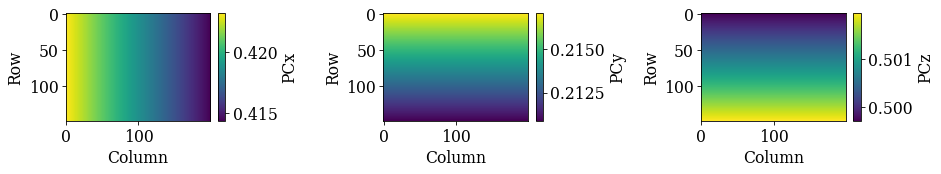

In [42]:
det_ext.plot_pc()

Finally, change detector shape to align with the dataset

In [43]:
det_ext.shape = s.detector.shape
det_ext

EBSDDetector (60, 60), px_size 70 um, binning 1, tilt 0.0, azimuthal 0, pc (0.419, 0.214, 0.501)

Save detector

In [44]:
det_ext.save("det_ext.txt")

## 4. Hough indexing

Create a new indexer with the extrapolated PCs

In [45]:
indexer = det_ext.get_indexer(pl)

Hough index all patterns

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.4188, 0.214, 0.5008)
  Indexing 29800 pattern(s) in 57 chunk(s)
Radon Time: 2.1627027930012446
Convolution Time: 3.3979629169984946
Peak ID Time: 2.692788385996664
Band Label Time: 4.240783465998902
Total Band Find Time: 12.495070572999794
Band Vote Time:  13.354898735000006
  Indexing speed: 1148.28532 patterns/s


<Figure size 480x360 with 0 Axes>

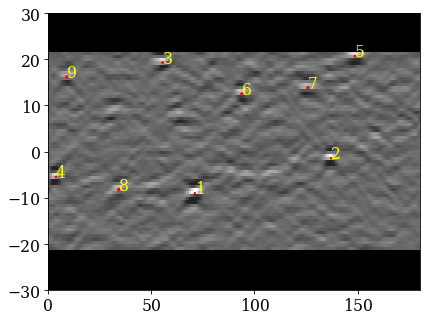

In [46]:
xmap_hi = s.hough_indexing(pl, indexer, verbose=2)

Check whether any patterns could not be indexed

In [47]:
xmap_hi

Phase    Orientations         Name  Space group  Point group  Proper point group     Color
   -1        1 (0.0%)  not_indexed         None         None                None         w
    0  29799 (100.0%)           ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm, pq, nmatch
Scan unit: um

Save the Hough indexing results

In [48]:
io.save("xmap_hi.h5", xmap_hi, overwrite=True)

Plot the pattern fit and confidence metric (CM) maps

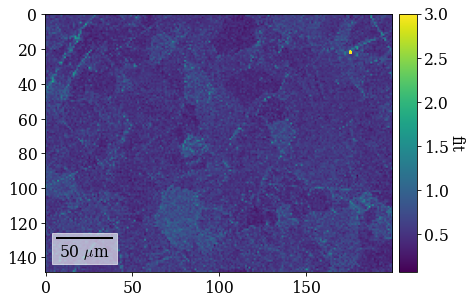

In [49]:
xmap_hi.plot("fit", colorbar=True, colorbar_label="fit", vmax=3)

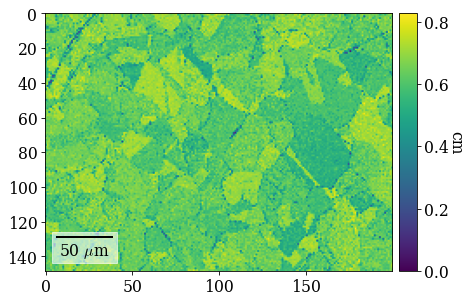

In [50]:
xmap_hi.plot("cm", colorbar=True, colorbar_label="cm")

Plot the orientation map (IPF-Z), where colors are given by the (symmetry reduced) crystal direction $\left<uvw\right>$ pointing in the into-plane direction

In [51]:
ckey = plot.IPFColorKeyTSL(xmap_hi.phases[0].point_group)

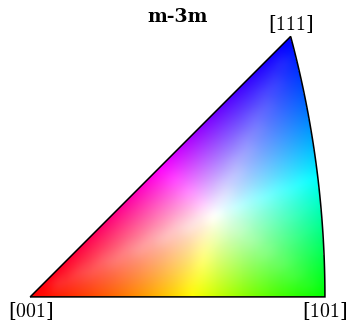

In [52]:
ckey.plot()

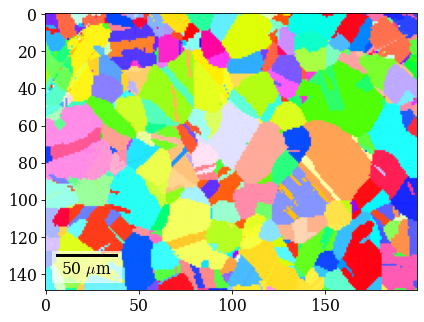

In [53]:
rgb_hi = ckey.orientation2color(xmap_hi.rotations)
xmap_hi.plot(rgb_hi)

Plot IPF-Z map overlayed with image quality

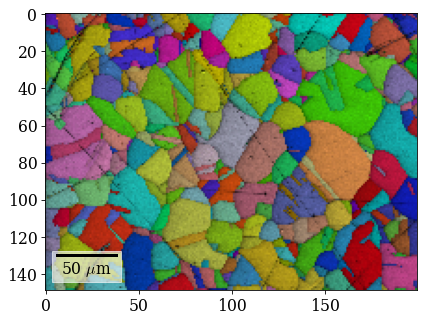

In [54]:
xmap_hi.plot(rgb_hi, overlay=iq.ravel())

Evaluate results by plotting geometrical simulations on top of patterns

In [55]:
sim_hi = simulator.on_detector(det_ext, xmap_hi.rotations.reshape(*xmap_hi.shape))

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.74 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 202.42 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 303.70 ms


In [56]:
# del s.metadata.Markers  # Uncomment to delete previously added markers
s.add_marker(sim_hi.as_markers(), permanent=True, plot_marker=False)

Create a navigator from the IPF-Z map

In [57]:
navi = kp.draw.get_rgb_navigator(rgb_hi.reshape(xmap_hi.shape + (3,)))

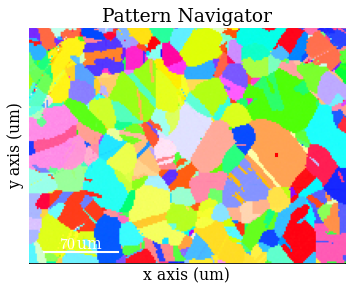

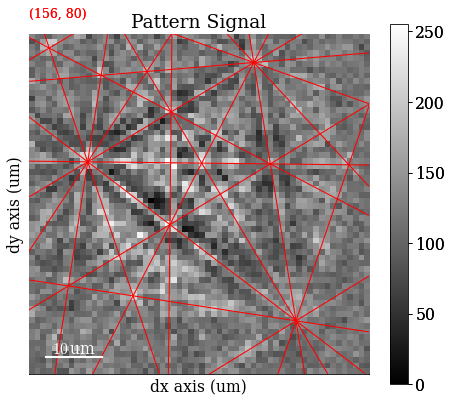

In [58]:
s.plot(navi)

## 5. Dictionary indexing

Dictionary indexing is more robust towards noise in EBSD patterns (resulting from e.g. overlapping bands, high degree of deformation etc.) than Hough indexing.
A dictionary consists of a series of (dynamically) simulated patterns projected from a master pattern, and we compare all experimental patterns to all these.

To create this dictionary, we need:
* Accurate detector-sample geometry (already done!)
* Master pattern (in the square Lambert projection)
* Sampling of all possible orientations (per phase)

Plot our geometrical simulation on top of the upper stereographic projection of our dynamically simulated Ni Kikuchi sphere

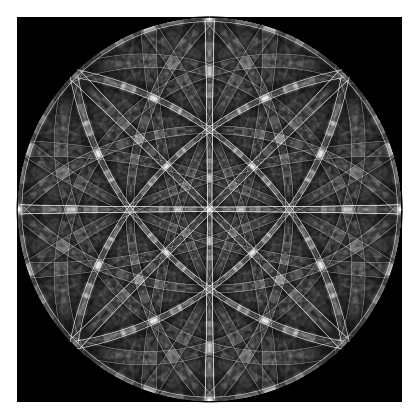

In [59]:
fig, ax = plt.subplots(subplot_kw=dict(projection="stereographic"), figsize=(7, 7))
simulator.plot(mode="bands", color="w", figure=fig)
ax.imshow(mp_sp.data, cmap="gray", extent=(-1, 1, -1, 1));

Discretely sample the complete orientation space of point group $m\bar{3}m$ (*Oh*) with an average misorientation of about 2$^{\circ}$ between rotations $\mathbf{g}$

In [60]:
g_sample = sampling.get_sample_fundamental(
    resolution=2, point_group=mp.phase.point_group
)
g_sample = Orientation(g_sample, symmetry=mp.phase.point_group)

In [61]:
g_sample

Orientation (100347,) m-3m
[[ 0.8541 -0.3536 -0.3536 -0.1435]
 [ 0.8541 -0.3536 -0.3536  0.1435]
 [ 0.8541 -0.3536 -0.1435 -0.3536]
 ...
 [ 0.8541  0.3536  0.1435  0.3536]
 [ 0.8541  0.3536  0.3536 -0.1435]
 [ 0.8541  0.3536  0.3536  0.1435]]

Plot a subset of sampled orientations in axis-angle space

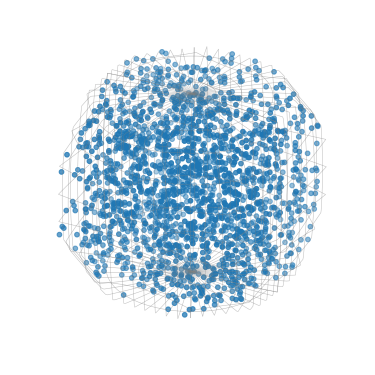

In [62]:
g_sample.get_random_sample(2000).scatter()

The dictionary requires a fixed PC

In [63]:
det1 = det_ext.deepcopy()
det1.pc = det1.pc_average

Set up generation of the dictionary of dynamically simulated patterns

In [64]:
s_dict = mp.get_patterns(g_sample, det1, energy=20, chunk_shape=2000)
s_dict

<LazyEBSD, title: , dimensions: (100347|60, 60)>

Inspect the five first patterns in the dictionary

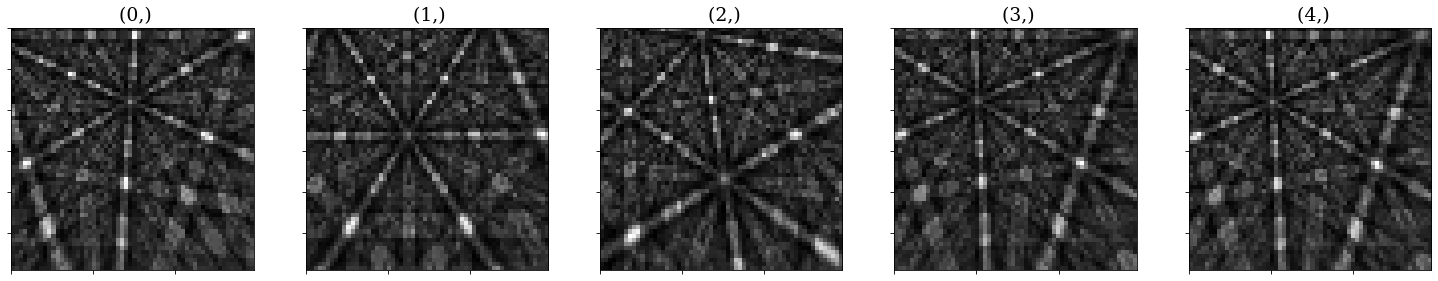

In [65]:
fig = plt.figure(figsize=(20, 4), layout="tight")
hs.plot.plot_images(s_dict.inav[:5], axes_decor=None, per_row=5, fig=fig, colorbar=False);

Perform dictionary indexing by generating a chunk of simulated patterns at a time and compare them to all the experimental patterns

In [66]:
xmap_di = s.dictionary_indexing(s_dict)

Dictionary indexing information:
  Phase name: ni
  Matching 29800 experimental pattern(s) to 100347 dictionary pattern(s)
  NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, navigation mask: False, signal mask: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:15<00:00,  5.00s/it]


  Indexing speed: 116.85684 patterns/s, 11726233.30355 comparisons/s


In [67]:
xmap_di

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  29800 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

The 20 best matches (rotations, scores and simulation indices) are kept

In [68]:
xmap_di.scores.shape

(29800, 20)

Plot similarity scores (normalized cross-correlation, NCC) between best matching
experimental and simulated patterns

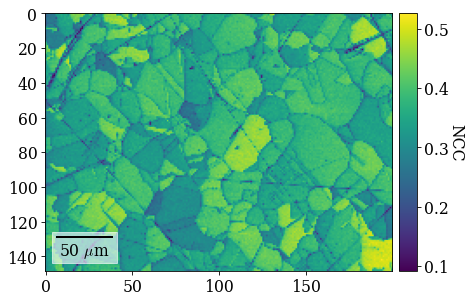

In [69]:
xmap_di.plot(xmap_di.scores[:, 0], colorbar=True, colorbar_label="NCC")

Plot IPF-Z orientation map

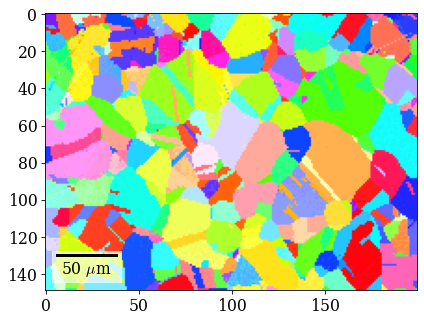

In [70]:
rgb_di = ckey.orientation2color(xmap_di.rotations[:, 0])
xmap_di.plot(rgb_di)

Save dictionary indexing results to file

In [71]:
io.save("xmap_di.h5", xmap_di)

## 6. Orientation refinement

During refinement, a better score $r$ is searched for iteratively by changing the orientation (and/or PC) slightly in a controlled manner using an optimization algorithm.
The default algorithm is the Nelder-Mead simplex from SciPy.
We here use that from the NLopt package (an optional dependency of kikuchipy), which has been found to be faster but equally accurate.

In [72]:
xmap_ref = s.refine_orientation(
    xmap=xmap_di,
    detector=det_ext,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    maxeval=100,
    trust_region=[2, 2, 2],
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [2 2 2]
  Relative tolerance: 0.0001
  Max. function evaulations: 100
Refining 29800 orientation(s):
[########################################] | 100% Completed | 196.53 s
Refinement speed: 151.55620 patterns/s


In [73]:
xmap_ref

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  29800 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, num_evals
Scan unit: um

Plot refined orientation map

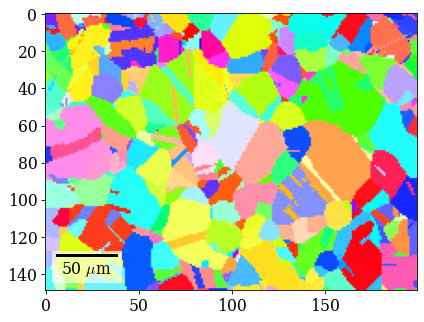

In [74]:
rgb_ref = ckey.orientation2color(xmap_ref.rotations)
xmap_ref.plot(rgb_ref)

Plot refined NCC scores

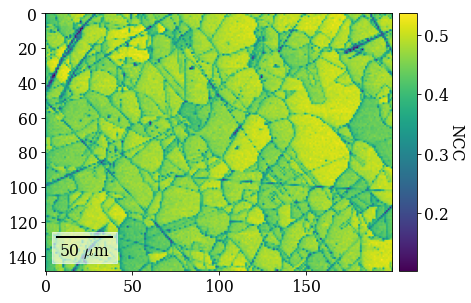

In [75]:
xmap_ref.plot(xmap_ref.scores, colorbar=True, colorbar_label="NCC")

Plot orientation map with scores overlayed

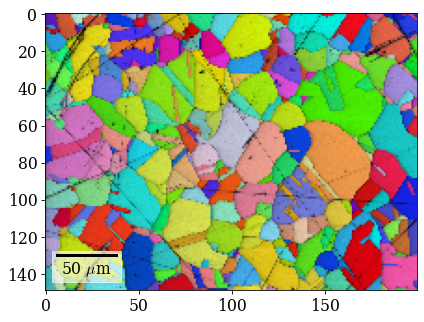

In [76]:
xmap_ref.plot(rgb_ref, overlay="scores")

Compare histogram of scores after DI and refinement

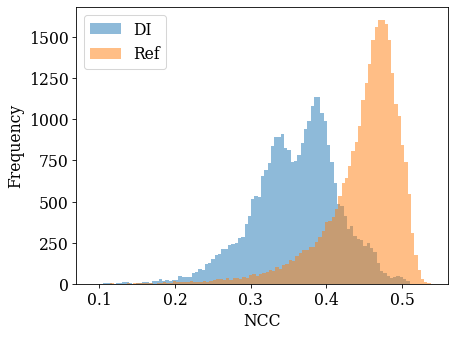

In [77]:
fig, ax = plt.subplots()
ax.hist(xmap_di.scores[:, 0], bins=100, color="C0", label="DI", alpha=0.5)
ax.hist(xmap_ref.scores, bins=100, color="C1", label="Ref", alpha=0.5)
ax.legend()
ax.set(xlabel="NCC", ylabel="Frequency");

Save final indexing results

In [78]:
io.save("xmap_ref.ang", xmap_ref)
io.save("xmap_ref.h5", xmap_ref)